# 纯股债风险平价组合

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [431]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [46]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [47]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [48]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI,CBA00401.CS,CBA02701.CS,000300.SH,000905.SH,000906.SH,000921.CSI,H00804.CSI
2019-03-14,4060.2550,28851.39,2808.48,189.3559,284.14,67.09,1519.0760,1072.1319,187.1989,176.2500,3698.4858,5298.5024,3964.2417,3974.5972,12973.3320
2019-03-15,4114.2750,29012.26,2822.48,189.3817,284.29,66.90,1519.1913,1069.9511,187.2474,176.2372,3745.0050,5359.0087,4012.9596,4013.7010,13187.0627
2019-03-18,4222.9233,29409.01,2832.94,189.4042,284.28,67.23,1519.5223,1067.1083,187.2294,176.3063,3851.7479,5501.1830,4125.3694,4112.8502,13460.4945
2019-03-19,4221.8907,29466.28,2832.57,189.4079,285.20,67.52,1519.6348,1071.0259,187.2335,176.3072,3833.9626,5522.1801,4114.9688,4097.2857,13485.8190
2019-03-20,4221.3026,29320.97,2824.23,189.4063,284.59,68.07,1519.7485,1065.2251,187.2106,176.3099,3835.4397,5515.7856,4114.9657,4109.9538,13533.0209


# 标准风险平价

In [49]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [496]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return np.abs(assets_risk_contribution)

In [497]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]
#     res = []
#     for i in range(assets_risk_contribution.shape[0]):
#         for j in range(assets_risk_contribution.shape[0]):
#             res.append((assets_risk_contribution[i, 0] - assets_risk_contribution[j, 0])**2)
#     error = sum(res)

    # It returns the calculated error
    return error

In [498]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [499]:
df = odf[['000906.SH', 'CBA00101.CS']]

In [500]:
df = df.replace([0], np.NAN)

In [501]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [502]:
covariances = ret_df.iloc[-242:].cov()

In [503]:
covariances*1e6

,000906.SH,CBA00101.CS
000906.SH,211.028348,-2.230275
CBA00101.CS,-2.230275,0.516628


### 计算权重

In [504]:
n = df.shape[1]
init_weights = np.array([0.5, 0.5])
assets_risk_budget = np.array([0.5, 0.5])
# assets_risk_budget = np.array([1. / n] * n)

In [505]:
assets_risk_budget

array([0.5, 0.5])

### 等权下的风险贡献

In [506]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [507]:
rc

matrix([[7.25475534e-03],
        [5.95412126e-05]])

### 计算权重

In [508]:
weights = _get_risk_parity_weights(covariances.values*1e6, assets_risk_budget, init_weights)

In [509]:
weights

array([0.04714618, 0.95285382])

In [510]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [511]:
rc

matrix([[0.00042946],
        [0.00042946]])

In [512]:
(rc / rc.sum()).reshape(-1) - assets_risk_budget

matrix([[ 2.16726006e-06, -2.16726006e-06]])

In [513]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 回测

In [514]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [515]:
new_df.head()

,000906.SH,CBA00101.CS
2005-01-05,995.576,105.9273
2005-01-06,986.216,105.5623
2005-01-07,987.693,105.7206
2005-01-10,997.186,105.6599
2005-01-11,1000.098,105.7978


In [516]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
assets_risk_budget = np.array([1./2, 1./2])
init_weights = np.array([0.1, 0.9])
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4:
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            wb = _get_risk_parity_weights(covariances.values*1e6, assets_risk_budget, init_weights)
            # check risk contribution
            rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)
            if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
                print(date)
                wb = temp.copy()

In [517]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [519]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

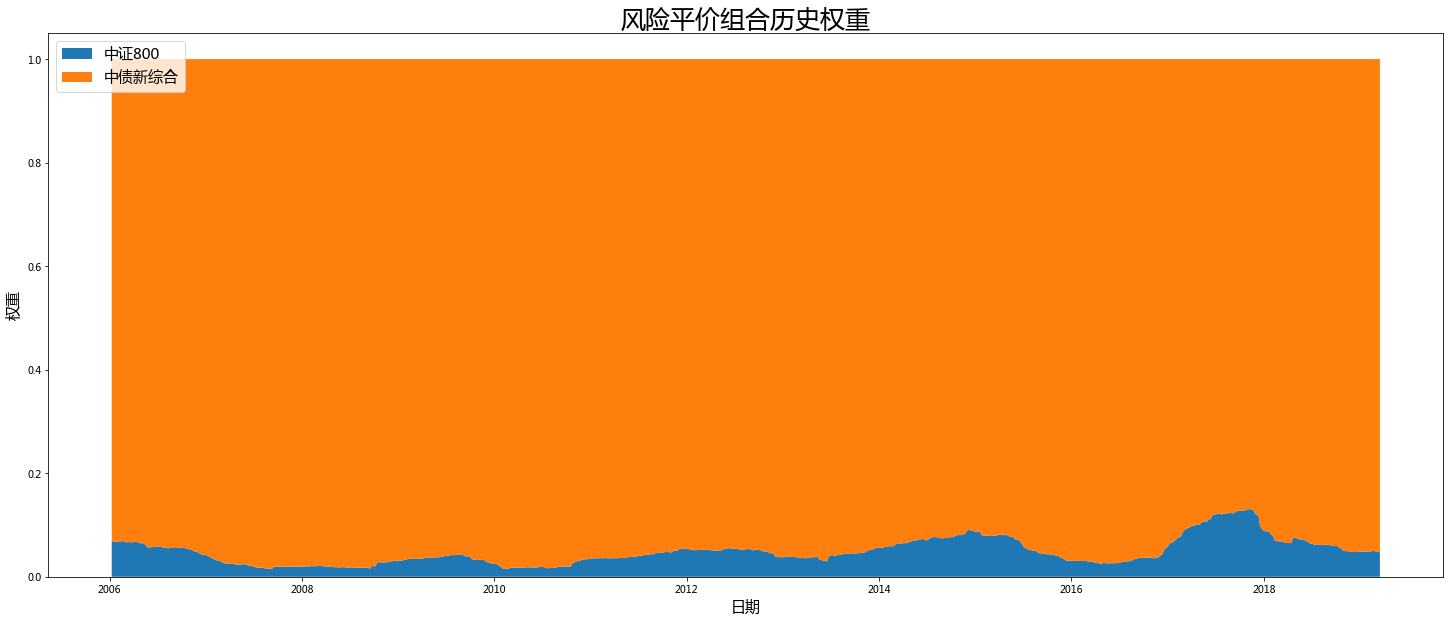

In [520]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['000906.SH'],
                 weight_plot['CBA00101.CS'], 
                 labels=[u'中证800', u'中债新综合'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/stock-bond-base_portfolio_weight.jpg', dpi=200, bbox_inches='tight')

In [521]:
metric(portfolio_ret)

Annual return: 4.92%
Sharpe ratio: 2.24
Annual volatility: 1.69%
Max drawdown: -3.64%


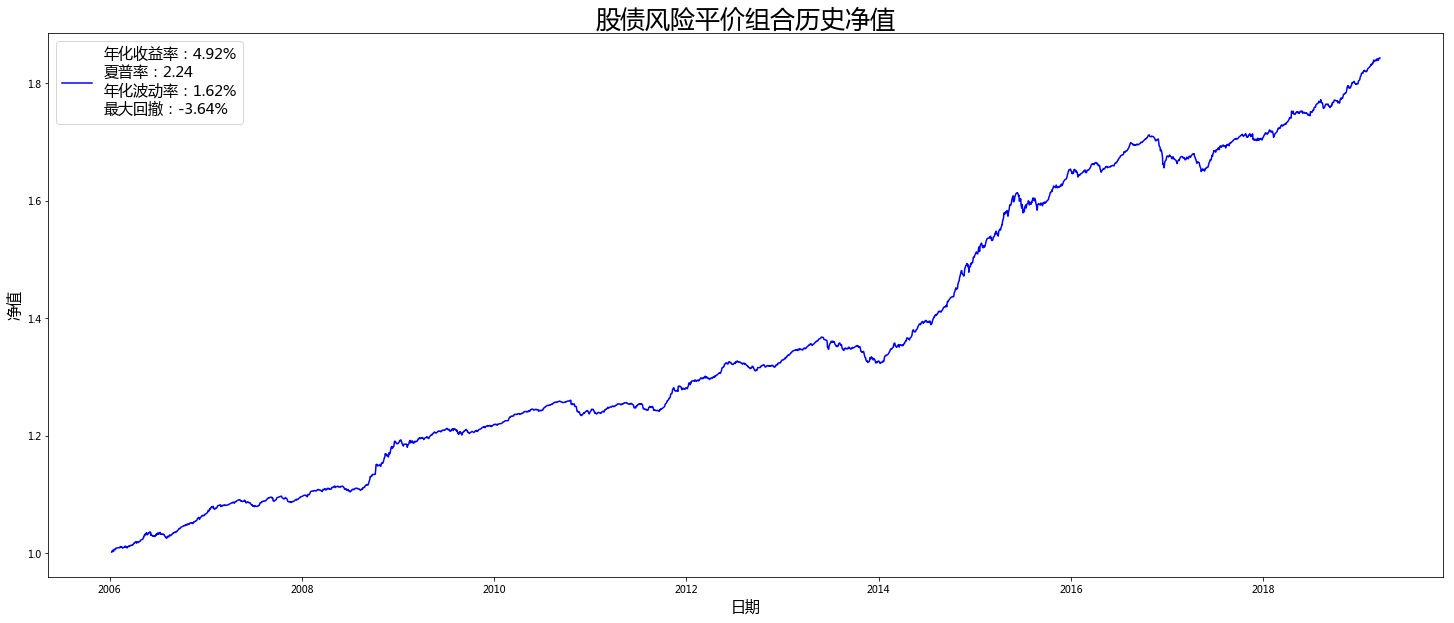

In [523]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue', 
        label=u'年化收益率：4.92%\n夏普率：2.24\n年化波动率：1.62%\n最大回撤：-3.64%')
ax.set_title(u'股债风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
ax.legend(loc='upper left', fontsize=15)
fig.savefig('../pic/stock-bond-base_portfolio_return.jpg', dpi=200, bbox_inches='tight')

# 今年以来风险平价组合与各类资产情况

In [524]:
fname = u'../data/stock-bond-base_stats.xlsx'

In [525]:
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

In [526]:
col_format = workbook.add_format({'bold': True, 'align': 'center', 'font_name': u'楷体', 'font_color': '#FFFFFF', 'bg_color': '#993333'})
cell_format = workbook.add_format({'font_name': u'楷体'})
percent_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00%'})
number_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00'})

In [527]:
worksheet.write('A1', '', col_format)
worksheet.write('B1', u'收益率(周)', col_format)
worksheet.write('C1', u'收益率(月)', col_format)
worksheet.write('D1', u'收益率(年)', col_format)
worksheet.write('E1', u'波动率(年)', col_format)
worksheet.write('F1', u'夏普率(年)', col_format)
worksheet.write('G1', u'当前权重', col_format)
worksheet.write('H1', u'风险贡献', col_format)

0

In [528]:
weights = weight.iloc[-1]

In [529]:
worksheet.write('A2', u'中证800', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['000906.SH']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['000906.SH']
rc = assets_risk_budget[0]
worksheet.write('B2', retw, percent_format)
worksheet.write('C2', retm, percent_format)
worksheet.write('D2', ret, percent_format)
worksheet.write('E2', vol, percent_format)
worksheet.write('F2', sh, number_format)
worksheet.write('G2', w, percent_format)
worksheet.write('H2', rc, percent_format)

0

In [530]:
worksheet.write('A3', u'中债新综合', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['CBA00101.CS']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['CBA00101.CS']
rc = assets_risk_budget[1]
worksheet.write('B3', retw, percent_format)
worksheet.write('C3', retm, percent_format)
worksheet.write('D3', ret, percent_format)
worksheet.write('E3', vol, percent_format)
worksheet.write('F3', sh, number_format)
worksheet.write('G3', w, percent_format)
worksheet.write('H3', rc, percent_format)

0

In [531]:
worksheet.write('A4', u'现金', cell_format)
s = odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change()
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = empyrical.cum_returns_final(s) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B4', retw, percent_format)
worksheet.write('C4', retm, percent_format)
worksheet.write('D4', ret, percent_format)
worksheet.write('E4', vol, percent_format)
worksheet.write('F4', sh, number_format)
worksheet.write('G4', 0, percent_format)
worksheet.write('H4', 0, percent_format)

0

In [532]:
worksheet.write('A5', u'风险平价组合', cell_format)
s = portfolio_ret[portfolio_ret.index >= '2019-01-01']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B5', retw, percent_format)
worksheet.write('C5', retm, percent_format)
worksheet.write('D5', ret, percent_format)
worksheet.write('E5', vol, percent_format)
worksheet.write('F5', sh, number_format)
worksheet.write('G5', 1, percent_format)
worksheet.write('H5', 1, percent_format)

0

In [533]:
worksheet.set_column(0, 0, 15)

0

In [534]:
workbook.close()